# Train Model

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
import shutil

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models, transforms

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [28]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

#DEVICE = torch.device('cpu')
print(f"Using device: {DEVICE}")

Using device: mps


## Preparando dados

In [29]:
path_raw = "../data/raw"
folder_raw = os.listdir(path_raw)

# Verificando a quantidade de imagens por label
qtd_labels = {
   pasta: len(os.listdir(os.path.join(path_raw, pasta))) for pasta in folder_raw
}
qtd_labels

{'cat': 1458, 'dog': 1458, 'otter': 1458}

In [30]:
# Criando pasta de treino e teste

processed_folder = "../data/processed"

dir_train = os.path.join(processed_folder, "train")
dir_validation = os.path.join(processed_folder, "validation")
dir_test = os.path.join(processed_folder, "test")

if not os.path.exists(dir_train): os.makedirs(dir_train)
if not os.path.exists(dir_validation): os.makedirs(dir_validation)
if not os.path.exists(dir_test): os.makedirs(dir_test)

In [31]:
for classes in folder_raw:
    dir_train_class = os.path.join(dir_train, classes)
    dir_validation_class = os.path.join(dir_validation, classes)
    dir_test_class = os.path.join(dir_test, classes)

    if not os.path.exists(dir_train_class): os.makedirs(dir_train_class)
    if not os.path.exists(dir_validation_class): os.makedirs(dir_validation_class)
    if not os.path.exists(dir_test_class): os.makedirs(dir_test_class)

    dir_class = os.path.join(path_raw, classes)
    files = os.listdir(dir_class)

    train, validation = train_test_split(files, test_size=0.2, random_state=42)
    validation, test = train_test_split(validation, test_size=0.5, random_state=42)
    
    print(f"Classe: {classes} - Train: {len(train)} - Validation: {len(validation)} - Test: {len(test)}")

    for file in train:
        origin = os.path.join(dir_class, file)
        destiny = os.path.join(dir_train_class, file)
        if not os.path.exists(destiny): shutil.copy(origin, destiny)

    for file in validation:
        origin = os.path.join(dir_class, file)
        destiny = os.path.join(dir_validation_class, file)
        if not os.path.exists(destiny): shutil.copy(origin, destiny)

    for file in test:
        origin = os.path.join(dir_class, file)
        destiny = os.path.join(dir_test_class, file)
        if not os.path.exists(destiny): shutil.copy(origin, destiny)

Classe: cat - Train: 1166 - Validation: 146 - Test: 146
Classe: dog - Train: 1166 - Validation: 146 - Test: 146
Classe: otter - Train: 1166 - Validation: 146 - Test: 146


## MobileNetV3

In [32]:
image_size = 224
batch_size = 32

In [33]:
image_transform = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ]),
}

In [34]:
dataset = {
    'train': datasets.ImageFolder(dir_train, transform=image_transform['train']),
    'validation': datasets.ImageFolder(dir_validation, transform=image_transform['validation']),
    'test': datasets.ImageFolder(dir_test, transform=image_transform['test'])
}

print(dataset)

{'train': Dataset ImageFolder
    Number of datapoints: 3497
    Root location: ../data/processed/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ), 'validation': Dataset ImageFolder
    Number of datapoints: 437
    Root location: ../data/processed/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ), 'test': Dataset ImageFolder
    Number of datapoints: 437
    Root location: ../data/processed/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )}


In [35]:
# Mapeando Indice para Label e salvando tamanho dos datasets de treino e teste
label_map = {index: class_name for class_name, index in dataset['train'].class_to_idx.items()}
label_map

{0: 'cat', 1: 'dog', 2: 'otter'}

In [36]:
# Criando dataloaders
dataloader_train = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset['test'], batch_size=batch_size, shuffle=True)

print(f"Train Dataloader: {len(dataloader_train)}")
print(f"Validation Dataloader: {len(dataloader_validation)}")
print(f"Test Dataloader: {len(dataloader_test)}")

Train Dataloader: 110
Validation Dataloader: 14
Test Dataloader: 14


In [37]:
def extract_features(model, dataloader):
    model = model.to(DEVICE)
    model.eval()

    features = []
    labels = []
    
    with torch.no_grad():
        for images, target in dataloader:
            images = images.to(DEVICE)
            features.append(model(images).cpu().numpy())
            labels.append(target.cpu().numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [38]:
mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
print(mobilenet)

for param in mobilenet.parameters():
    param.requires_grad = False

mobilenet.classifier[3] = nn.Linear(1024, 512)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [39]:
train_features, train_labels = extract_features(mobilenet, dataloader_train)
validation_features, validation_labels = extract_features(mobilenet, dataloader_validation)
test_features, test_labels = extract_features(mobilenet, dataloader_test)

In [40]:
import xgboost as xgb

In [42]:
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_map),
    eval_metric='mlogloss',
    max_depth=6,
    n_estimators=1000,
    early_stopping_rounds=10
)

model_xgb.fit(train_features, train_labels, eval_set=[(validation_features, validation_labels)], verbose=True)

[0]	validation_0-mlogloss:0.82300
[1]	validation_0-mlogloss:0.65177
[2]	validation_0-mlogloss:0.53540
[3]	validation_0-mlogloss:0.44666
[4]	validation_0-mlogloss:0.38076
[5]	validation_0-mlogloss:0.32955
[6]	validation_0-mlogloss:0.29248
[7]	validation_0-mlogloss:0.26294
[8]	validation_0-mlogloss:0.24165
[9]	validation_0-mlogloss:0.22234
[10]	validation_0-mlogloss:0.20820
[11]	validation_0-mlogloss:0.19558
[12]	validation_0-mlogloss:0.18531
[13]	validation_0-mlogloss:0.17280
[14]	validation_0-mlogloss:0.16763
[15]	validation_0-mlogloss:0.16044
[16]	validation_0-mlogloss:0.15293
[17]	validation_0-mlogloss:0.14758
[18]	validation_0-mlogloss:0.14508
[19]	validation_0-mlogloss:0.14031
[20]	validation_0-mlogloss:0.13803
[21]	validation_0-mlogloss:0.13604
[22]	validation_0-mlogloss:0.13303
[23]	validation_0-mlogloss:0.12977
[24]	validation_0-mlogloss:0.12792
[25]	validation_0-mlogloss:0.12645
[26]	validation_0-mlogloss:0.12514
[27]	validation_0-mlogloss:0.12359
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [43]:
preds = model_xgb.predict(test_features)
accuracy = metrics.accuracy_score(test_labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9405


In [45]:
import joblib

joblib.dump(model_xgb, '../model/model_xgb.joblib')
torch.save(mobilenet.to(torch.device('cpu')), '../model/mobilenet.pth')

TypeError: to() received an invalid combination of arguments - got (type), but expected one of:
 * (torch.device device, torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (Tensor tensor, bool non_blocking, bool copy, *, torch.memory_format memory_format)


## Testando Predict

In [58]:
from PIL import Image

(-0.5, 223.5, 223.5, -0.5)

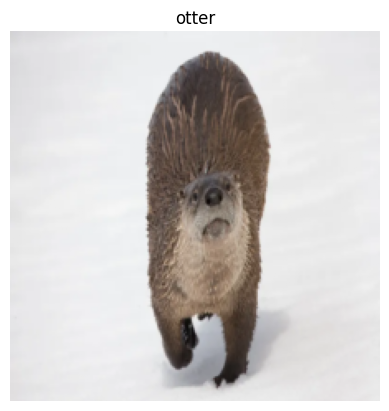

In [84]:
image_size = 224
image_path = "../data/otter_test.jpg"
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    features = mobilenet(image).cpu().numpy()

predict = model_xgb.predict(features)

plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title(label_map[predict[0]])
plt.axis('off')